In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!apt-get install octave
!pip install oct2py
%load_ext oct2py.ipython
!git clone https://github.com/sccn/eeglab.git
!git clone --recurse-submodules https://github.com/sccn/eeglab.git

In [4]:
import numpy as np
import pandas as pd
import scipy
from oct2py import octave
import mne
import h5py
from tqdm import tqdm
import os
import pywt

In [5]:
!pip install -q keras-tcn
!pip install keras
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 32.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.3.2 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras.backend as K
from keras.layers import Dense, Input, Conv2D, Reshape, Flatten, Dropout,MaxPooling2D,LSTM,SimpleRNN
from keras.initializers import glorot_normal
from keras.models import Model
from keras import optimizers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score
from tcn import TCN
from keras.models import Sequential
from keras.optimizers import SGD,Adam

In [7]:
octave.addpath('/content/eeglab/functions/adminfunc');
octave.addpath('/content/eeglab/functions/popfunc');
octave.addpath('/content/eeglab/functions/adminfunc');
octave.addpath('/content/eeglab/functions/sigprocfunc');
octave.addpath('/content/eeglab/functions/miscfunc');
octave.addpath('/content/eeglab/functions/statistics');
octave.addpath('/content/eeglab/functions/studyfunc');
octave.addpath('/content/eeglab/functions/supportfiles');
octave.addpath('/content/eeglab/functions/timefreqfunc');

In [8]:
def list2arr(*argv):
	out = np.empty(len(argv),dtype=np.object)
	for i in range(len(argv)):
		out[i] = argv[i]
	return out

In [9]:
def process_sources(item, matPathBase, setPathBase):
	matName = f'{item}_Depression_REST'
	matItem = matPathBase + matName + '.mat'
	# load mat filr
	matData = scipy.io.loadmat(matItem)
	matData = octave.eeg_checkset(matData)
	setPathBase = f'{item}.set'
	# save data as set file
	scipy.io.savemat(setPathBase,matData)
"""
	octave.pop_saveset(matData, filename=f'{item}.set',
						filepath=setPathBase, savemode='onefile',
						check='on');
"""

"\n\toctave.pop_saveset(matData, filename=f'{item}.set',\n\t\t\t\t\t\tfilepath=setPathBase, savemode='onefile',\n\t\t\t\t\t\tcheck='on');\n"

In [10]:
def process_signal(raw):
	## Set reference
	raw.set_eeg_reference(ref_channels=['M1', 'M2'])

	## Drop Bad Channels
	raw.drop_channels([x for x in ['CB1', 'CB2', 'EKG', 'HEOG', 'VEOG'] if x in raw.ch_names])

	## Remove Baseline
	raw._data = mne.baseline.rescale(raw.get_data(), raw.times, (None, None))

	## Apply notch filter
	raw.notch_filter(50)

	## Apply Frequency Band Filter
	#delta .5 - 4
	#theta 4 - 8
	#alpha 8 - 13
	#c 13 - 30
	raw.filter(.2, 45, method='iir', verbose='WARNING')

	## Apply Butter Filter
	lowcut = 1.0
	highcut = 50.0
	order = 5
	nyq = 0.5 * raw.info['sfreq']
	low = lowcut / nyq
	high = highcut / nyq
	b, a = scipy.signal.butter(order, [low, high], btype='band')
	raw._data = scipy.signal.lfilter(b, a, raw.get_data())

	## Apply ICA Decomposition
	ica = mne.preprocessing.ICA(max_iter=100, random_state=1)
	ica.fit(raw)
	ica.apply(raw)
	return raw

In [11]:
def epoching(item, setPathBase, epochPathBase, valid_events):
	setItem = setPathBase + f'{item}' + '.set'
	fepoch = epochPathBase + f'{item}' + '_epo'
	ftimes = epochPathBase + f'{item}' + '_ept'
	## Read SET file
	raw = mne.io.read_raw_eeglab(setItem)
	## Fetch Events
	events, event_id = mne.events_from_annotations(raw)
	event_id = dict((k.replace('.0',''),v) for k,v in event_id.items())
	event_id_swapd = dict((v,k) for k,v in event_id.items())
	## Process signal
	raw = process_signal(raw)
	## Apply Epoching
	epochs = {}
	times = {}
	maxI = len(events) - 1
	prev_ev_name = None
	for i,ev in enumerate(events):
		ev_name = event_id_swapd[ev[2]]
		if ev_name not in valid_events:
			continue
		tmin = ev[0]
		if i == maxI:
			tmax = raw._data.shape[1]
		else:
			tmax = events[i+1][0]
			if len(events) > i+2 and ev[-1] not in [14,15] and events[i+1][-1] in [14,15]:
				ccc,j = 0,1
				while( events[i+j][-1] in [14,15] ): ccc+=1;j+=1;
				last = events[i+j]
				if (ev[-1] in [1,9,10,11,12,13]
					and (last[-1] == ev[-1] or last[0]-tmin <= 270)
					or (last[-1] != ev[-1] and tmax-tmin < 174 and last[0]-tmin <= 176)
					):
					tmax = last[0]
		dd = raw._data[:,tmin:tmax].transpose()
		tt = raw.times[tmin:tmax]
		if epochs.get(ev_name) is None:
			epochs[ev_name] = [[dd]]
			times[ev_name] = [[tt]]
		else:
			if prev_ev_name == ev_name:
				epochs[ev_name][-1].append(dd)
				times[ev_name][-1].append(tt)
			else:
				epochs[ev_name].append([dd])
				times[ev_name].append([tt])
		prev_ev_name = ev_name
	if len(epochs) < len(valid_events):
		print('Subject does not have all events:',item)
		return False
	epochsNp = []
	timesNp = []
	for ev in valid_events:
		epochsNp.append(np.array([list2arr(*x) for x in epochs[ev]]))
		timesNp.append(np.array([list2arr(*x) for x in times[ev]]))
	epochsNp = list2arr(*epochsNp)
	timesNp = list2arr(*timesNp)
	np.save(fepoch, epochsNp)
	np.save(ftimes, timesNp)
	return True

In [12]:
def features_of_channel(data, timesdiff):
	if len(data) < 3:
		return None
	sfreq = 500
	dwt='db4'
	# DWT - Discrete Wavelet Transform
	cA,cD = pywt.dwt(data, dwt)
	# DWT - FFT of Approximation
	cAf = np.fft.fft(cA)
	# DWT - FFT of Details
	cDf = np.fft.fft(cD)
	# Diff - First Order Difference
	diff1 = np.diff(data)
	# Diff - Second Order Difference
	diff2 = np.diff(data,n=2)
	# Diff - Variance of First Order Difference
	diff1Var = np.mean(diff1 ** 2)
	# Hjorth - Activity
	activity = np.var(data)
	# Hjorth - Mobility
	mobility = np.sqrt(diff1Var / activity)
	# Hjorth - Complexity
	complexity = np.sqrt(np.mean(diff2 ** 2) / diff1Var) / mobility
	# FFT - Fast Fourier Transform
	fft1 = np.fft.fft(data)
	# FFT - ABS(FFT)
	fft1abs = np.abs(fft1.real)
	# Bands - Delta/Theta/Alpha/Beta

	bands = {
	  'delta':{'freq':(0.5,4),'sum': 0,'max': 0},
	  'theta':{'freq':(4,8)  ,'sum': 0,'max': 0},
	  'alpha':{'freq':(8,13) ,'sum': 0,'max': 0},
	  'beta' :{'freq':(13,30),'sum': 0,'max': 0},
	}

	shape1sfreq = float(data.shape[0])/sfreq
	for band,bandDict in bands.items():
		arange = np.arange(bandDict['freq'][0]*shape1sfreq,
							bandDict['freq'][1]*shape1sfreq, dtype=int)
		bandDict['sum'] = np.sum(fft1abs.real[arange])
		bandDict['max'] = np.max(fft1abs.real[arange])

	# Vertex to Vertex Slope
	diff1Slope = diff1/timesdiff
	result = np.array([
						np.min(data),                                #   'Min'
						np.max(data),                                #   'Max'
						np.std(data),                                #   'STD'
						np.mean(data),                               #   'Mean'
						np.median(data),                             #   'Median'
						activity,                                    #   'Activity'
						mobility,                                    #   'Mobility'
						complexity,                                  #   'Complexity'
						scipy.stats.kurtosis(data),                  #   'Kurtosis'
						np.mean(diff2),                              #   '2nd Difference Mean'
						np.max(diff2),                               #   '2nd Difference Max'
						np.mean(diff1),                              #   '1st Difference Mean'
						np.max(diff1),                               #   '1st Difference Max'
						scipy.stats.variation(data),                 #   'Coeffiecient of Variation'
						scipy.stats.skew(data),                      #   'Skewness'
						np.mean(cA),                                 #   'Wavelet Approximate Mean'
						np.std(cA),                                  #   'Wavelet Approximate Std Deviation'
						np.mean(cD),                                 #   'Wavelet Detailed Mean'
						np.std(cD),                                  #   'Wavelet Detailed Std Deviation'
						np.sum(np.abs(cAf) ** 2) / cAf.size,         #   'Wavelet Approximate Energy'
						np.sum(np.abs(cDf) ** 2) / cDf.size,         #   'Wavelet Detailed Energy'
						-np.sum(cA * np.nan_to_num(np.log(cA))),     #   'Wavelet Approximate Entropy'
						-np.sum(cD * np.nan_to_num(np.log(cD))),     #   'Wavelet Detailed Entropy'
						np.mean(diff1Slope),                         #   'Mean of Vertex to Vertex Slope'
						np.var(diff1Slope),                          #   'Var  of Vertex to Vertex Slope'
						bands['delta']['max'],                       #   'FFT Delta Max Power'
						bands['theta']['max'],                       #   'FFT Theta Max Power'
						bands['alpha']['max'],                       #   'FFT Alpha Max Power'
						bands['beta' ]['max'],                       #   'FFT Beta Max Power'
						bands['delta']['sum']/bands['alpha']['sum'], #   'Delta/Alpha'
						bands['delta']['sum']/bands['theta']['sum'], #   'Delta/Theta'
						])
	return result

In [13]:
def extract_features(item, epochPathBase, featPathBase):
	fepoch = epochPathBase + f'{item}' + '_epo.npy'
	ftimes = epochPathBase + f'{item}' + '_ept.npy'
	featPath = featPathBase + f'{item}' + '_feat'

	epochs = np.load(fepoch, allow_pickle=True)
	times  = np.load(ftimes, allow_pickle=True)
	ft = []
	# per event
	for ev in range(len(epochs)):
		# per epochs sequence
		ft.append([])
		for epo_gr in range(len(epochs[ev])):
			# per single epoch
			ft[-1].append([])
			for epo in range(len(epochs[ev][epo_gr])):
				# per channel
				timesdiff = np.diff(times[ev][epo_gr][epo])
				ft[-1][-1].append([])
				for ch in range(epochs[ev][epo_gr][epo].shape[1]):
					res = features_of_channel(epochs[ev][epo_gr][epo][:,ch], timesdiff)
					if res is not None:
						ft[-1][-1][-1].append(res)
					if not len(ft[-1][-1][-1]):
						del ft[-1][-1][-1]
				ft[-1][-1][-1] = np.array(ft[-1][-1][-1])
			ft[-1][-1] = np.array(ft[-1][-1])
		ft[-1] = np.concatenate(ft[-1])
	ft = list2arr(*ft)
	np.save(featPath, ft)
	return True

In [14]:
def pad_N_epochs(x,limit):
	out = []
	for y in x:
		while len(y) < limit:
			y = np.concatenate([y,y[-(limit-len(y)):]])
		out.append(y[:limit])
	return np.array(out)

In [15]:
def load_featured_data(featPathBase, labelPath, itemNums):
	# load labels file
	labels_data = pd.ExcelFile(labelPath)
	labels_data = labels_data.parse('Depression Rest')
	# load feature data
	data = []
	labels = []
	counter = 0
	for item in itemNums:
		counter += 1
		featPath = featPathBase + f'{item}' + '_feat.npy'
		temp_data = np.load(featPath, allow_pickle=True)
		temp_data = pad_N_epochs(temp_data, 120)
		temp_data = temp_data.reshape(temp_data.shape[0], temp_data.shape[1], -1)
		data.append(temp_data)
		lab = labels_data[labels_data['id']==item].BDI.values[0]*np.ones(temp_data.shape[0])
		labels.append(lab)

	data = np.concatenate(data)
	labels = np.concatenate(labels).astype('uint8')
	return data, labels

In [18]:
from tqdm import tqdm
#itemNums = [*range(507, 544), *range(545, 571), *range(573, 629)]
#itemNums = [507,563,565,574]

valid_events = ['1', '2', '3', '4', '5', '6', '11', '12', '13', '14', '15', '16']

matPathBase = '/content/drive/MyDrive/Depression Rest/Matlab Files/'
setPathBase = '/content/drive/MyDrive/depset/'
labelPath = '/content/drive/MyDrive/Depression Rest/labels.xlsx'



epochPathBase = '/content/drive/MyDrive/epoched_data/'
featPathBase = '/content/drive/MyDrive/extracted_features/'

CREATE_SET_FILES = True
DO_EPOCHING = True
EXTRACT_FEATURES = True

In [17]:
"""
for item in tqdm(itemNums):
  process_sources(item, matPathBase, setPathBase)
for item in tqdm(itemNums):
  epoching(item, setPathBase, epochPathBase, valid_events)
for item in tqdm(itemNums):
  extract_features(item, epochPathBase, featPathBase)
"""

'\nfor item in tqdm(itemNums):\n  process_sources(item, matPathBase, setPathBase)\nfor item in tqdm(itemNums):\n  epoching(item, setPathBase, epochPathBase, valid_events)\nfor item in tqdm(itemNums):\n  extract_features(item, epochPathBase, featPathBase)\n'

In [20]:
def model_arch(input_dim, timesteps):
  #Assuming you have 'timesteps' and 'input_dim' defined
  num_classes = 3  # Number of classes in your classification task

  # Model architecture
  krl_init = glorot_normal(seed=42)

  i = Input(shape=(timesteps, input_dim, 1), name='inp')
  h = Conv2D(filters=64, kernel_size=5, strides=(3, 3), activation='relu',
            name='conv2_1', kernel_initializer=krl_init, data_format='channels_last')(i)
  h = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu',
            name='conv2_2', kernel_initializer=krl_init, data_format='channels_last')(h)
  s = K.int_shape(h)
  h = Reshape((s[1], s[2]*s[3]))(h)
  h = TCN(return_sequences=True, nb_filters=50, kernel_size=3, kernel_initializer=krl_init,
          nb_stacks=1, padding='causal', dilations=[1, 2, 4], activation='relu', name='tcn1')(h)
  h = Flatten(name='flt')(h)
  h = Dropout(0.5, name='drp1')(h)
  h = Dense(512, activation='relu', name='fc1')(h)
  h = Dense(num_classes, activation='softmax', name='output')(h)  # Using 'softmax' for multi-class classification

  model = Model(inputs=i, outputs=h)
  adamopt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model

In [21]:
def train_model(train_x, train_y):
    sc = StandardScaler()
    # standardize data
    for i in range(train_x.shape[0]):
        sc.partial_fit(train_x[i])
    for i in range(train_x.shape[0]):
        train_x[i] = sc.transform(train_x[i])
    train_y = to_categorical(train_y, num_classes=3)
    # prepare shape of data
    (_, timesteps, num_feats) = train_x.shape
    train_x = np.expand_dims(train_x, axis=-1)
    # define model
    K.clear_session()
    model = model_arch(num_feats, timesteps)
    # train model
    model.fit(train_x, train_y, batch_size=7, epochs=50,
              shuffle=True, verbose=0)

    return model, sc

In [16]:
itemNums = [507,508,513,514,566,628,594,610,611,561,565,567,569,558,586,515,518,616,509,510,511,513,525,617,621,622,625,559,590,592]
valid_events = ['1', '2', '3', '4', '5', '6', '11', '12', '13', '14', '15', '16']

In [19]:
X, Y = load_featured_data(featPathBase, labelPath, itemNums)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 120, 1550, 1)]    0         
                                                                 
 conv2_1 (Conv2D)            (None, 39, 516, 64)       1664      
                                                                 
 conv2_2 (Conv2D)            (None, 19, 257, 64)       36928     
                                                                 
 reshape (Reshape)           (None, 19, 16448)         0         
                                                                 
 tcn1 (TCN)                  (None, 19, 50)            3327450   
                                                                 
 flt (Flatten)               (None, 950)               0         
                                                                 
 drp1 (Dropout)              (None, 950)               0     

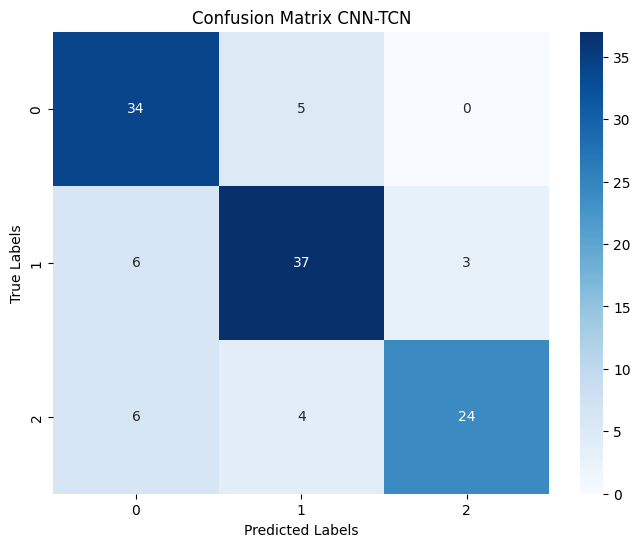

In [29]:
# select training and test data
#train_x, test_x = X[train_index], X[test_index]
#train_y, test_y = Y[train_index], Y[test_index]
# model training
train_x, test_x,train_y, test_y  = train_test_split(X, Y, test_size=0.33, random_state=21,shuffle=True)
model, scaler = train_model(train_x, train_y)
# standardize test data
for i in range(test_x.shape[0]):
    test_x[i] = scaler.transform(test_x[i])
# prepare shape of data
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)
# Evaluate the model
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(test_y, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix CNN-TCN')
plt.show()

In [40]:
print(classification_report(test_y, y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        39
           1       0.80      0.80      0.80        46
           2       0.89      0.71      0.79        34

    accuracy                           0.80       119
   macro avg       0.81      0.79      0.80       119
weighted avg       0.81      0.80      0.80       119



In [30]:
# Assuming you have train_x, train_y, test_x, and test_y
train_x, test_x,train_y, test_y  = train_test_split(X, Y, test_size=0.33, random_state=21,shuffle=True)

# Define input shape
sc = StandardScaler()
# standardize data
for i in range(train_x.shape[0]):
    sc.partial_fit(train_x[i])
for i in range(train_x.shape[0]):
    train_x[i] = sc.transform(train_x[i])
train_y = to_categorical(train_y, num_classes=3)
# prepare shape of data
(_, timesteps, num_feats) = train_x.shape
train_x = np.expand_dims(train_x, axis=-1)

input_dim = num_feats

num_classes = 3  # Number of classes in your classification task

In [31]:
# CNN model architecture
krl_init = 'glorot_normal'

i_cnn = Input(shape=(timesteps, input_dim, 1), name='inp_cnn')
h_cnn = Conv2D(filters=64, kernel_size=5, strides=(3, 3), activation='relu',
               name='conv2_1', kernel_initializer=krl_init, data_format='channels_last')(i_cnn)
h_cnn = MaxPooling2D(pool_size=(2, 2))(h_cnn)
h_cnn = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu',
               name='conv2_2', kernel_initializer=krl_init, data_format='channels_last')(h_cnn)
h_cnn = MaxPooling2D(pool_size=(2, 2))(h_cnn)
h_cnn = Flatten(name='flt')(h_cnn)
h_cnn = Dense(512, activation='relu', name='fc1')(h_cnn)
output_cnn = Dense(num_classes, activation='softmax', name='output')(h_cnn)

# Create and compile CNN model
cnn_model = Model(inputs=i_cnn, outputs=output_cnn)
adamopt = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)
cnn_model.summary()

Epoch 1/50
8/8 [==============================] - 11s 1s/step - loss: 1.3665 - accuracy: 0.3029
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 1.0365 - accuracy: 0.5062
Epoch 3/50
8/8 [==============================] - 17s 2s/step - loss: 0.9422 - accuracy: 0.6017
Epoch 4/50
8/8 [==============================] - 15s 1s/step - loss: 0.8674 - accuracy: 0.6722
Epoch 5/50
8/8 [==============================] - 13s 2s/step - loss: 0.7847 - accuracy: 0.7718
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.6954 - accuracy: 0.7801
Epoch 7/50
8/8 [==============================] - 12s 1s/step - loss: 0.6115 - accuracy: 0.8340
Epoch 8/50
8/8 [==============================] - 11s 1s/step - loss: 0.5239 - accuracy: 0.9212
Epoch 9/50
8/8 [==============================] - 11s 1s/step - loss: 0.4507 - accuracy: 0.9212
Epoch 10/50
8/8 [==============================] - 13s 2s/step - loss: 0.4058 - accuracy: 0.9046
Epoch 11/50
8/8 [======================

In [32]:
# RNN model architecture
i_rnn = Input(shape=(timesteps, input_dim), name='inp_rnn')
h_rnn = SimpleRNN(units=64, activation='relu', return_sequences=True)(i_rnn)
h_rnn = SimpleRNN(units=32, activation='relu')(h_rnn)
output_rnn = Dense(num_classes, activation='softmax', name='output')(h_rnn)

# Create and compile RNN model
rnn_model = Model(inputs=i_rnn, outputs=output_rnn)
rnn_model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train RNN model
rnn_model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)
rnn_model.summary()

Epoch 1/50
8/8 [==============================] - 3s 148ms/step - loss: 3.0115 - accuracy: 0.2988
Epoch 2/50
8/8 [==============================] - 1s 188ms/step - loss: 1.2638 - accuracy: 0.4440
Epoch 3/50
8/8 [==============================] - 2s 245ms/step - loss: 0.9617 - accuracy: 0.5394
Epoch 4/50
8/8 [==============================] - 2s 242ms/step - loss: 0.8397 - accuracy: 0.6266
Epoch 5/50
8/8 [==============================] - 2s 258ms/step - loss: 0.7355 - accuracy: 0.7261
Epoch 6/50
8/8 [==============================] - 2s 258ms/step - loss: 0.6529 - accuracy: 0.7884
Epoch 7/50
8/8 [==============================] - 2s 235ms/step - loss: 0.5881 - accuracy: 0.8548
Epoch 8/50
8/8 [==============================] - 1s 135ms/step - loss: 0.5387 - accuracy: 0.8797
Epoch 9/50
8/8 [==============================] - 1s 137ms/step - loss: 0.4947 - accuracy: 0.9046
Epoch 10/50
8/8 [==============================] - 1s 141ms/step - loss: 0.4565 - accuracy: 0.9253
Epoch 11/50
8/8 [==

In [33]:
# LSTM model architecture
i_lstm = Input(shape=(timesteps, input_dim), name='inp_lstm')
h_lstm = LSTM(units=64, activation='relu', return_sequences=True)(i_lstm)
h_lstm = LSTM(units=32, activation='relu')(h_lstm)
output_lstm = Dense(num_classes, activation='softmax', name='output')(h_lstm)

# Create and compile LSTM model
lstm_model = Model(inputs=i_lstm, outputs=output_lstm)
lstm_model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)
lstm_model.summary()

Epoch 1/50
8/8 [==============================] - 8s 562ms/step - loss: 23.1925 - accuracy: 0.4315
Epoch 2/50
8/8 [==============================] - 3s 416ms/step - loss: 275.7946 - accuracy: 0.5311
Epoch 3/50
8/8 [==============================] - 2s 298ms/step - loss: 403.4172 - accuracy: 0.5104
Epoch 4/50
8/8 [==============================] - 2s 294ms/step - loss: 308.3578 - accuracy: 0.4813
Epoch 5/50
8/8 [==============================] - 2s 309ms/step - loss: 586.0015 - accuracy: 0.4896
Epoch 6/50
8/8 [==============================] - 3s 409ms/step - loss: 1062.1085 - accuracy: 0.4938
Epoch 7/50
8/8 [==============================] - 5s 571ms/step - loss: 6066.4756 - accuracy: 0.4855
Epoch 8/50
8/8 [==============================] - 4s 512ms/step - loss: 16934.9199 - accuracy: 0.4772
Epoch 9/50
8/8 [==============================] - 2s 302ms/step - loss: 208362.3906 - accuracy: 0.5062
Epoch 10/50
8/8 [==============================] - 3s 311ms/step - loss: 21033.2305 - accuracy

In [34]:
i_tcn = Input(shape=(timesteps, input_dim), name='inp_tcn')
h_tcn = TCN(return_sequences=True, nb_filters=50, kernel_size=3, kernel_initializer=krl_init,
            nb_stacks=1, padding='causal', dilations=[1, 2, 4], activation='relu')(i_tcn)
h_tcn = Flatten(name='flt')(h_tcn)
h_tcn = Dropout(0.5, name='drp1')(h_tcn)
output_tcn = Dense(num_classes, activation='softmax', name='output')(h_tcn)

# Create and compile TCN model
tcn_model = Model(inputs=i_tcn, outputs=output_tcn)
adamopt = Adam(learning_rate=0.0001)
tcn_model.compile(optimizer=adamopt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train TCN model
tcn_model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)
tcn_model.summary()

Epoch 1/50
8/8 [==============================] - 3s 241ms/step - loss: 1.9336 - accuracy: 0.3527
Epoch 2/50
8/8 [==============================] - 3s 353ms/step - loss: 1.2512 - accuracy: 0.4232
Epoch 3/50
8/8 [==============================] - 3s 433ms/step - loss: 1.3769 - accuracy: 0.5145
Epoch 4/50
8/8 [==============================] - 4s 437ms/step - loss: 1.1161 - accuracy: 0.5809
Epoch 5/50
8/8 [==============================] - 3s 320ms/step - loss: 0.8711 - accuracy: 0.6058
Epoch 6/50
8/8 [==============================] - 2s 234ms/step - loss: 0.8403 - accuracy: 0.6473
Epoch 7/50
8/8 [==============================] - 2s 230ms/step - loss: 0.6731 - accuracy: 0.7220
Epoch 8/50
8/8 [==============================] - 2s 234ms/step - loss: 0.7084 - accuracy: 0.6929
Epoch 9/50
8/8 [==============================] - 2s 236ms/step - loss: 0.6718 - accuracy: 0.7344
Epoch 10/50
8/8 [==============================] - 2s 267ms/step - loss: 0.5613 - accuracy: 0.7967
Epoch 11/50
8/8 [==

4/4 [==============================] - 1s 87ms/step


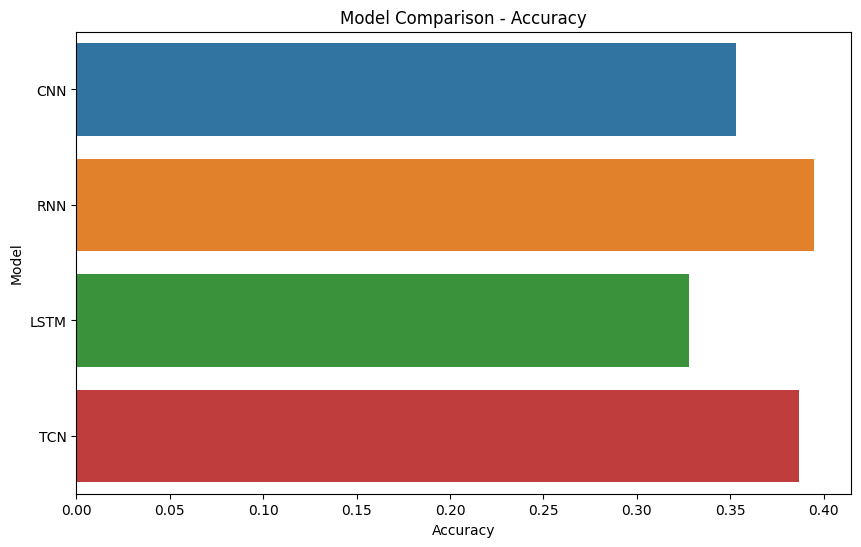

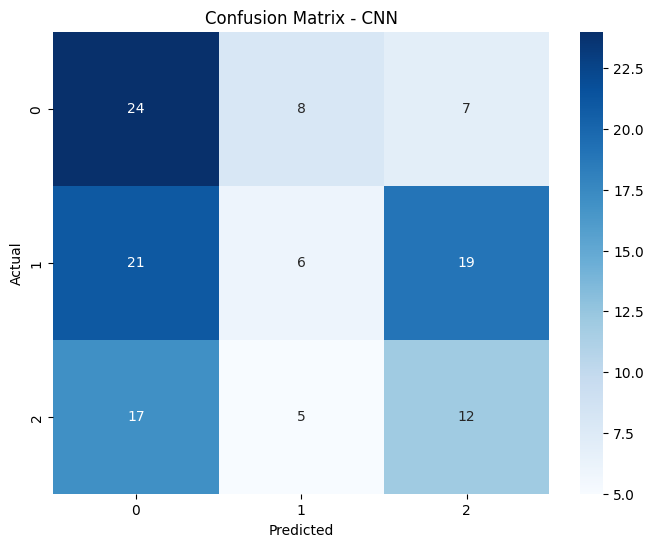

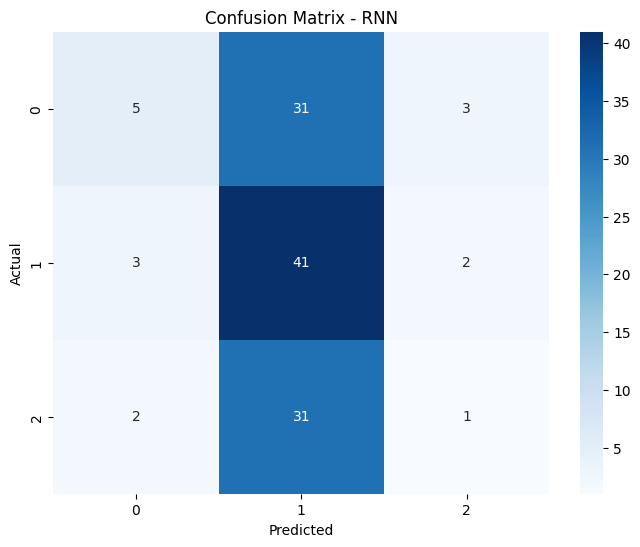

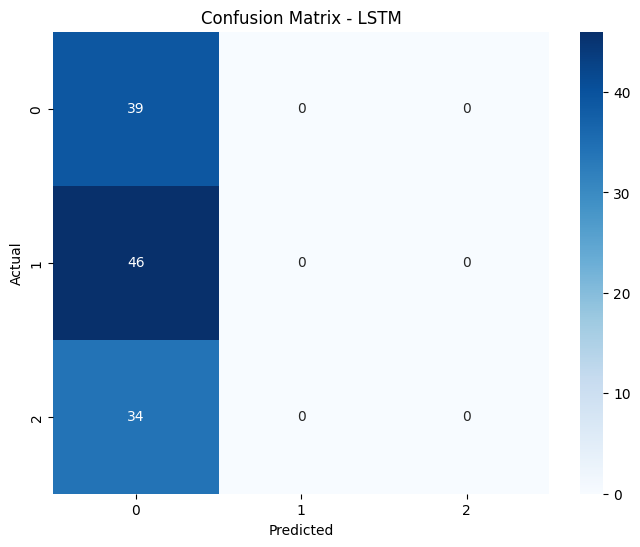

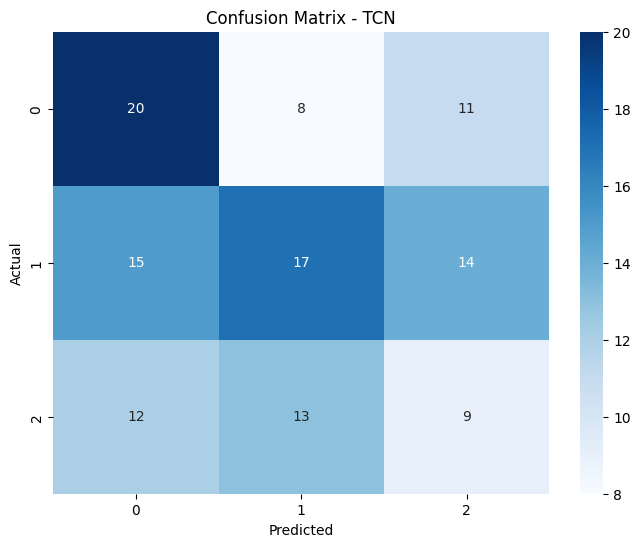

In [35]:
#for i in range(test_x.shape[0]):
#    test_x[i] = scaler.transform(test_x[i])

test_x = np.expand_dims(test_x, axis=-1)

# Make predictions using the models
cnn_predictions = np.argmax(cnn_model.predict(test_x), axis=-1)
rnn_predictions = np.argmax(rnn_model.predict(test_x), axis=-1)
lstm_predictions = np.argmax(lstm_model.predict(test_x), axis=-1)
tcn_predictions = np.argmax(tcn_model.predict(test_x), axis=-1)

# Compare accuracies
model_names = ['CNN', 'RNN', 'LSTM', 'TCN']
accuracies = [accuracy_score(test_y, cnn_predictions),
              accuracy_score(test_y, rnn_predictions),
              accuracy_score(test_y, lstm_predictions),
              accuracy_score(test_y, tcn_predictions)]

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Comparison - Accuracy')
plt.show()

# Confusion matrix for CNN
conf_matrix_cnn = confusion_matrix(test_y, cnn_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_cnn, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()

conf_matrix_rnn= confusion_matrix(test_y, rnn_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_rnn, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RNN')
plt.show()

conf_matrix_lstm = confusion_matrix(test_y, lstm_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_lstm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

conf_matrix_tcn = confusion_matrix(test_y, tcn_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_tcn, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TCN')
plt.show()


In [36]:
print(classification_report(test_y, cnn_predictions))

              precision    recall  f1-score   support

           0       0.39      0.62      0.48        39
           1       0.32      0.13      0.18        46
           2       0.32      0.35      0.33        34

    accuracy                           0.35       119
   macro avg       0.34      0.37      0.33       119
weighted avg       0.34      0.35      0.32       119



In [37]:
print(classification_report(test_y, rnn_predictions))

              precision    recall  f1-score   support

           0       0.50      0.13      0.20        39
           1       0.40      0.89      0.55        46
           2       0.17      0.03      0.05        34

    accuracy                           0.39       119
   macro avg       0.35      0.35      0.27       119
weighted avg       0.37      0.39      0.29       119



In [38]:
print(classification_report(test_y, lstm_predictions))

              precision    recall  f1-score   support

           0       0.33      1.00      0.49        39
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        34

    accuracy                           0.33       119
   macro avg       0.11      0.33      0.16       119
weighted avg       0.11      0.33      0.16       119



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(classification_report(test_y, tcn_predictions))

              precision    recall  f1-score   support

           0       0.43      0.51      0.47        39
           1       0.45      0.37      0.40        46
           2       0.26      0.26      0.26        34

    accuracy                           0.39       119
   macro avg       0.38      0.38      0.38       119
weighted avg       0.39      0.39      0.38       119

